In [1]:
from keras.models import load_model
import h5py
# returns a compiled model
# identical to the previous one
model = load_model('mymodel.h5')

Using TensorFlow backend.


In [2]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 2

valdatagen = ImageDataGenerator()
test_generator = valdatagen.flow_from_directory(
    directory='test', 
        shuffle = False,
        target_size=(299,299),  # all images will be resized to 299x299
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 190 images belonging to 2 classes.


In [3]:
import numpy as np
test_steps = np.math.ceil(test_generator.samples / test_generator.batch_size)
eval_res = model.evaluate_generator(test_generator, steps=test_steps, max_q_size=10, workers=1, pickle_safe=False)
print(model.metrics_names, '\n',eval_res)

['loss', 'acc'] 
 [0.19935440919116923, 0.95789473684210524]


In [4]:
predictions = model.predict_generator(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [5]:
class_labels

['NonViolence', 'Violence']

In [6]:
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

             precision    recall  f1-score   support

NonViolence       0.74      0.81      0.77        89
   Violence       0.82      0.75      0.78       101

avg / total       0.78      0.78      0.78       190



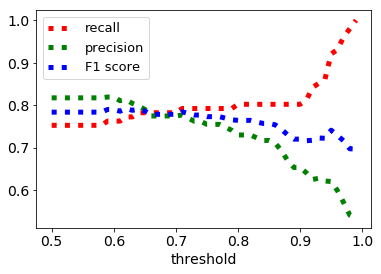

In [7]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
rcParams['font.size'] = 14


def Plot_Metrics(my_threshold):
    Recall = np.zeros(len(my_threshold))
    Precision = np.zeros(len(my_threshold))
    F1 = np.zeros(len(my_threshold))
    
    for j in range(len(my_threshold)):
        my_thre = my_threshold[j]
        my_predicted_classes = []
        for i in range(len(predictions)):
            if predictions[i][0] > my_thre: #1st i NonViolence 
                my_predicted_classes.append(0)
            else:
                my_predicted_classes.append(1)
        my_predicted_classes = np.array(my_predicted_classes)
        Recall[j] = recall_score(true_classes, my_predicted_classes, labels=class_labels, pos_label=1, average='binary', sample_weight=None)
        Precision[j] = precision_score(true_classes, my_predicted_classes, labels=class_labels, pos_label=1, average='binary', sample_weight=None)
        F1[j] = f1_score(true_classes, my_predicted_classes, labels=class_labels, pos_label=1, average='binary', sample_weight=None)
    
    fig = plt.figure()
    plt.style.use('seaborn-bright') 
    plt.plot(my_threshold, Recall, 'r:', label='recall', linewidth=5)
    plt.plot(my_threshold, Precision, 'g:', label='precision', linewidth=5)
    plt.plot(my_threshold, F1, 'b:', label='F1 score', linewidth=5)
    plt.xlabel('threshold')
    plt.legend(loc='best', prop={'family':'sans', 'size':'13'})
    fig.savefig('test1_metrics.png', dpi=fig.dpi)


my_threshold = np.linspace(0.5, 0.99)
Plot_Metrics(my_threshold)

In [ ]:
class_labels

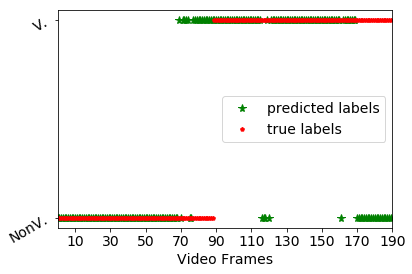

In [8]:
fig = plt.figure()

plt.plot(predicted_classes,'g*',label='predicted labels',markersize=8)
plt.plot(true_classes,'rp', label='true labels',markersize=4)
ax = plt.gca()

ax.set_yticks(ticks=[0,1])
ax.set_yticklabels(labels=['NonV.','V.'],rotation=30)
plt.legend()
plt.xticks(np.linspace(10,190,10))
plt.xlim([0,190])
plt.xlabel('Video Frames')

fig.savefig('test1_predictions.png', dpi=fig.dpi)



In [ ]:
predicted_classes[120]

In [9]:
#mislabeled 
img_path = 'test/Violence/violent31.jpg'
#img_path = 'test/Violence/violent41.jpg'

In [10]:
import cv2
from keras.models import *
from keras.callbacks import *
import keras.backend as K


In [11]:
original_img = cv2.imread(img_path, 1)

In [12]:
width, height, _ = original_img.shape

In [13]:
img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])

In [14]:
class_weights = model.layers[-1].get_weights()[0]

In [15]:
last_conv_layer = model.get_layer(name='conv2d_94')

In [16]:
last_conv_layer.output

<tf.Tensor 'conv2d_94/convolution:0' shape=(?, ?, ?, 192) dtype=float32>

In [17]:
get_output = K.function([model.layers[0].input], [last_conv_layer.output, model.layers[-1].output])
#conv2d_94

In [18]:
print(model.layers[-1].output)
print(last_conv_layer.output)
print(model.layers[0].input)

Tensor("dense_2/Softmax:0", shape=(?, 2), dtype=float32)
Tensor("conv2d_94/convolution:0", shape=(?, ?, ?, 192), dtype=float32)
Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32)


In [19]:
import numpy as np
from matplotlib import pyplot as plt

from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

#from vis.utils import utils
#from vis.utils.vggnet import VGG16
#from vis.visualization import visualize_saliency


# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_name = 'dense_1'
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]



In [20]:
# Images corresponding to tiger, penguin, dumbbell, speedboat, spider
image_paths = ["test/Violence/violent31.jpg"
]
from vis.utils import utils
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_saliency
from vis.visualization import visualize_cam



heatmaps = []
for path in image_paths:
    seed_img = utils.load_img(path, target_size=(224, 224))
    x = np.expand_dims(img_to_array(seed_img), axis=0)
    x = preprocess_input(x)
    pred_class = np.argmax(model.predict(x))

    # Here we are asking it to show attention such that prob of `pred_class` is maximized.
    saliency = visualize_saliency(model, layer_idx, [pred_class], seed_img)
    
    #filter_indices = [22]
    #heatmap = visualize_cam(model, layer_idx, filter_indices, seed_img, penultimate_layer_idx=None, alpha=0.5)

    heatmaps.append(saliency)





/Users/gulsedaunal/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working on filters: [1]


/Users/gulsedaunal/anaconda/lib/python3.5/site-packages/vis/visualization.py:169: RuntimeWarning: invalid value encountered in true_divide
  grads /= np.max(grads)
/Users/gulsedaunal/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/Users/gulsedaunal/anaconda/lib/python3.5/site-packages/vis/visualization.py:171: RuntimeWarning: invalid value encountered in less
  heatmap[np.where(grads < 0.2)] = 0


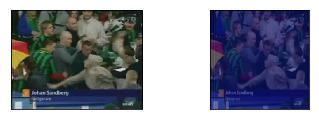

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig =  plt.figure()

image = mpimg.imread("test/Violence/violent31.jpg")
plt.subplot(221)
plt.imshow(image)
plt.xticks([])
plt.yticks([])


plt.subplot(222)
plt.imshow(utils.stitch_images(heatmaps))
plt.xticks([])
plt.yticks([])
plt.show()

fig.savefig('test_mislabelled_salients.png',dpi=fig.dpi)




 

/Users/gulsedaunal/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working on filters: [1]


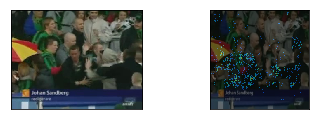

In [22]:
# Images corresponding to tiger, penguin, dumbbell, speedboat, spider
image_paths = ["test/Violence/violent41.jpg"
]
from vis.utils import utils
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_saliency
from vis.visualization import visualize_cam



heatmaps = []
for path in image_paths:
    seed_img = utils.load_img(path, target_size=(224, 224))
    x = np.expand_dims(img_to_array(seed_img), axis=0)
    x = preprocess_input(x)
    pred_class = np.argmax(model.predict(x))

    # Here we are asking it to show attention such that prob of `pred_class` is maximized.
    saliency = visualize_saliency(model, layer_idx, [pred_class], seed_img)
    
    #filter_indices = [22]
    #heatmap = visualize_cam(model, layer_idx, filter_indices, seed_img, penultimate_layer_idx=None, alpha=0.5)

    heatmaps.append(saliency)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig =  plt.figure()

image = mpimg.imread("test/Violence/violent41.jpg")
plt.subplot(221)
plt.imshow(image)
plt.xticks([])
plt.yticks([])


plt.subplot(222)
plt.imshow(utils.stitch_images(heatmaps))
plt.xticks([])
plt.yticks([])
plt.show()

fig.savefig('test_correctlabeled_salients.png',dpi=fig.dpi)




 




/Users/gulsedaunal/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working on filters: [1]


/Users/gulsedaunal/anaconda/lib/python3.5/site-packages/vis/visualization.py:169: RuntimeWarning: invalid value encountered in true_divide
  grads /= np.max(grads)
/Users/gulsedaunal/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/Users/gulsedaunal/anaconda/lib/python3.5/site-packages/vis/visualization.py:171: RuntimeWarning: invalid value encountered in less
  heatmap[np.where(grads < 0.2)] = 0


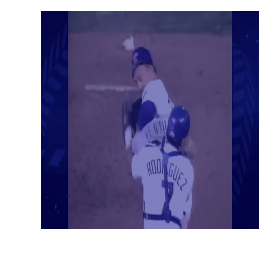

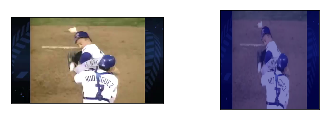

In [23]:
# Images corresponding to tiger, penguin, dumbbell, speedboat, spider
image_paths = ["video3/Frames/Violence/video3trim12.jpg"
]
from vis.utils import utils
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_saliency

heatmaps = []
for path in image_paths:
    seed_img = utils.load_img(path, target_size=(224, 224))
    x = np.expand_dims(img_to_array(seed_img), axis=0)
    x = preprocess_input(x)
    pred_class = np.argmax(model.predict(x))

    # Here we are asking it to show attention such that prob of `pred_class` is maximized.
    heatmap = visualize_saliency(model, layer_idx, [pred_class], seed_img)
    heatmaps.append(heatmap)


plt.axis('off')
plt.imshow(utils.stitch_images(heatmaps))
plt.show()


fig =  plt.figure()

image = mpimg.imread("video3/Frames/Violence/video3trim12.jpg")
plt.subplot(221)
plt.imshow(image)
plt.xticks([])
plt.yticks([])


plt.subplot(222)
plt.imshow(utils.stitch_images(heatmaps))
plt.xticks([])
plt.yticks([])
plt.show()

fig.savefig('vid3_salient.png',dpi=fig.dpi)






In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("video3/Frames/Violence/video3trim12.jpg")
plt.imshow(image)
plt.show()